In [24]:
# For FFT using the pffft library, length must round as follows:
# N=(2^a)*(3^b)*(5^c), a >= 5, b >=0, c >= 0 (32, 48, 64, 96, 128, 144, 160, etc are all acceptable lengths)

for a in range(5, 15):
    for b in range(0, 10):
        for c in range(0, 10):
            num = 2**a*3**b*5**c
            if num > 7500 and num < 8500:
                print(f"a{a}b{b}c{c}: {2**a*3**b*5**c}")


a5b5c0: 7776
a6b0c3: 8000
a9b1c1: 7680
a13b0c0: 8192


In [13]:
from sympy import factorint

Fs = 48000
Ts = 1 / Fs
# White noise length
noise_dur_s = 0.2
#Nw = int(noise_dur_s * Fs )
Nw = 5000
# Nw needs to be > 3000 (empirical tests)


# Rec length needs to be Nw + around 20m? worth of sample time
# (20m / 343 m/s) * 48000 = around 2800 samples
record_len = Nw + 2776

valid_correlation_len = record_len - Nw + 1
# length of noise will be padded with zeros to get the same size (to make the multiplication in FFT domain possible)

# For FFT using the pffft library, length must round as follows:
# N=(2^a)*(3^b)*(5^c), a >= 5, b >=0, c >= 0 (32, 48, 64, 96, 128, 144, 160, etc are all acceptable lengths)
factors = factorint(record_len)
print(factors)
assert(2 in factors)
assert(factors[2] >=5)
factors.pop(2, None)
factors.pop(3, None)
factors.pop(5, None)
assert(len(factors) == 0)


{2: 9, 5: 2}


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# FIR filter
filter_order = 1000001 
cutoffs = [20000, 24000]
fir_coeff = sp.signal.firwin(filter_order, cutoffs[0], pass_zero='highpass', window='hann', fs=Fs)
#sp.signal.freqz(fir_coeff, plot=lambda w, h: plt.plot(w*Fs/np.pi/2, 10 * np.log10(np.abs(h))))
#plt.show()

## Generate noise
def make_noise(seed):
    rng = np.random.default_rng(seed)
    #white_noise = rng.normal(size=Nw)
    white_noise = rng.uniform(-1, 1, size=Nw)
    #white_noise = rng.integers(-1, 2, size=Nw)
    #white_noise = rng.integers(2, size=Nw)*2 - 1
    #white_noise = np.cbrt(rng.uniform(-1, 1, size=Nw))
    # plot filter
    

    # Applying the FIR filter to the white noise
    filtered_noise = sp.signal.convolve(white_noise, fir_coeff, mode='same')

    # plot noise
    #noise_fft = sp.fft.rfft(filtered_noise)
    #n=len(noise_fft)
    #f = np.arange(n)*Fs/n
    #plt.figure()
    #plt.plot(f, 10 * np.log10(np.abs(noise_fft)))
    #plt.show()

    return filtered_noise / max(filtered_noise)

def find_best():
    #best = [(342.2706718109584, 475), (324.6178989845563, 610), (314.40676006689534, 765), (306.90171254949576, 945)] normal
    #best = [(349.86595152077996, 570), (341.6711598993898, 797), (339.4818560786098, 914), (333.3386605738086, 564)] normal cbrt
    #best = [(351.7215412072412, 249), (344.19256566735055, 374), (343.7115056538295, 603), (343.263657362925, 932)] uniform
    #best = [(347.8643989325651, 81), (346.809523996641, 535), (345.6884970965836, 847), (338.65933868385787, 972)] randint
    best = [(0, -1)]*4
    for i in range(1000):
        noise = make_noise(i)
        m = np.sum(noise**2)
        for j in range(4):
            if m > best[j][0]:
                best[j] = (m, i)
                break
    print(best)
#find_best()
filtered_noise = make_noise(704)
filtered_noise2 = make_noise(992)
filtered_noise3 = make_noise(701)
filtered_noise4 = make_noise(834)

In [ ]:
np.save("filtered_noise1.npy", filtered_noise)
np.save("filtered_noise2.npy", filtered_noise2)
np.save("filtered_noise3.npy", filtered_noise3)
np.save("filtered_noise4.npy", filtered_noise4)

In [ ]:
for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"pico_play_noise/sound_samples{i}.h", "w") as f:
        noise *= 2**15
        noise = np.asarray(noise, dtype='uint16')
        hexed = [f"0x{sample:04X}" for sample in noise]
        f.write("#include <stddef.h> // for size_t\n")
        f.write("#include <stdint.h> // for uint16_t\n")
        f.write("\n")
        f.write(f"#define SOUND_SAMPLES_LEN {len(hexed)}\n")
        f.write("\n")
        f.write("//These are actually signed ints \n")
        f.write("const uint16_t sound_samples[SOUND_SAMPLES_LEN] = {\n")
        for window in range(0, len(hexed), 10):
            s = "    " + ", ".join(hexed[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")


In [23]:
for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"pico_record_noise/sound_correlation{i}.h", "w") as f:
        padded = np.pad(noise, (0, record_len-Nw), 'constant', constant_values=0)
        #print(len(padded))
        fft = np.fft.rfft(padded)
        #print(len(fft))
        conj = np.conj(fft)
        scaled = conj/np.max(np.abs(conj)) * 2**24
        # length of RFFT is N/2+1 complex numbers
        # We interleave the real and floats
        # Thus we have N+2 floats
        interleaved = np.zeros(len(padded)+2, dtype='uint32') 
        interleaved[0::2] = np.asarray(scaled.real, dtype='uint32')
        interleaved[1::2] = np.asarray(scaled.imag, dtype='uint32')
        interleaved = [f"0x{f:08X}" for f in interleaved]
        
        f.write("#include <stddef.h> // for size_t\n")
        f.write("\n")
        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")
        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")
        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")
        f.write("\n")
        f.write(f"#define FFT_SIZE {record_len}\n")
        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")
        f.write("\n")
        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")
        f.write("const uint32_t sound_samples_fft_conj[CONV_BUFFER_SIZE] = {\n")
        for window in range(0, len(interleaved), 10):
            s = "    " + ", ".join(interleaved[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")


400 1000 1200 1300


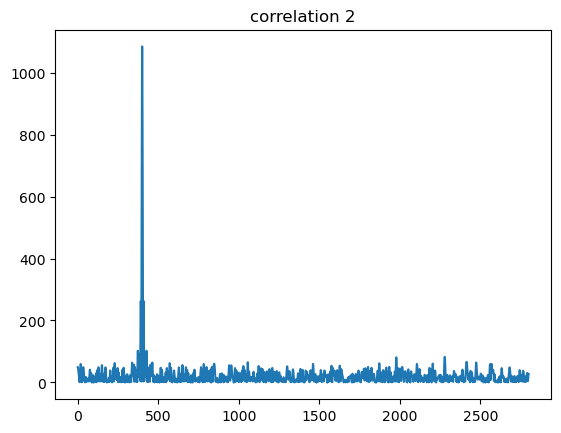

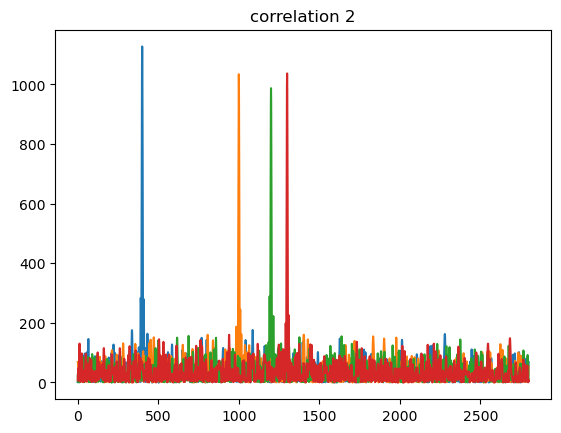

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sound_correlation

Fs = 48000

recording_noise_1 = np.zeros(record_len)
recording_noise_2 = np.zeros(record_len)
recording_noise_3 = np.zeros(record_len)
recording_noise_4 = np.zeros(record_len)

insert_loc = 400
recording_noise_1[insert_loc:insert_loc+Nw] += filtered_noise
insert_loc2 = 1000
recording_noise_2[insert_loc2:insert_loc2+Nw] += filtered_noise2
insert_loc3 = 1200
recording_noise_3[insert_loc3:insert_loc3+Nw] += filtered_noise3
insert_loc4 = 1300
recording_noise_4[insert_loc4:insert_loc4+Nw] += filtered_noise4

recording_noise_together = recording_noise_1 + recording_noise_2 + recording_noise_3 + recording_noise_4
#recording_noise_together = recording_noise_together / max(recording_noise_together)

plt.figure()
ind1 = sound_correlation.correlate_and_find_delay(recording_noise_1, filtered_noise)
plt.figure()
ind1 = sound_correlation.correlate_and_find_delay(recording_noise_together, filtered_noise)
ind2 = sound_correlation.correlate_and_find_delay(recording_noise_together, filtered_noise2)
ind3 = sound_correlation.correlate_and_find_delay(recording_noise_together, filtered_noise3)
ind4 = sound_correlation.correlate_and_find_delay(recording_noise_together, filtered_noise4)
print(ind1, ind2, ind3, ind4)


['-1316826', '-1014313', '-1549030', '-3267140', '-3722209', '-4555779', '-4522518', '-3512547', '-2283439', '-2809834', '-1384793', '1847397', '1589138', '737317', '-1514148', '-2198496', '-24425', '929216', '3013130', '2073159', '-284456', '-781431', '1623449', '3005057', '2445749', '2552886', '406337', '-506780', '-4740321', '-5742427', '-4655081', '-4005537', '-2881800', '30245', '-1265278', '-3968384', '-5016032', '-2736729', '-940663', '1866338', '1542900', '-103271', '-1273347', '-1196353', '41230', '-1869925', '-1706630', '-77745', '-2274699', '39583', '-528867', '230942', '1563797', '1298072', '-2253143', '-5471473', '-2776526', '1003904', '-451950', '-597452', '-2361976', '-4430206', '-970334', '560558', '1213845', '-218351', '-1918009', '-3855698', '-4257531', '-1907090', '2435830', '3444974', '3105191', '-1200066', '-4616827', '-760105', '2209856', '1432223', '-1076502', '-3947033', '-3774592', '-860620', '895566', '-2088282', '-3484496', '-1458139', '1770721', '2560341', '

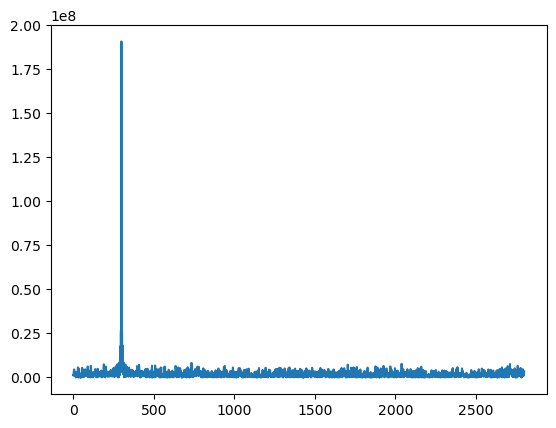

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

thing = """"""

y = thing.splitlines()
print(y)
y = [abs(int(s)) for s in y]

plt.plot(y)


In [ ]:
import serial
import scipy as sp
import numpy as np 

fs, samples = sp.io.wavfile.read("song3.wav")
samples = samples // 32
print(fs, samples.dtype)
assert(samples.dtype == np.int16)
sample_bytes = samples.tobytes()

ser = serial.Serial("/dev/ttyACM0", 115200)
ser.write(sample_bytes)
ser.flush()
print("done")

In [ ]:
import serial
import scipy as sp
import numpy as np 

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(b"r")
b = ser.read(48000 * 2 * 5)

#samples = np.frombuffer(b, dtype=np.uint32)
#samples = (samples)
#samples = np.frombuffer(samples.tobytes(), dtype=np.int32)
samples = np.frombuffer(b, dtype=np.int16)
import sounddevice as sd

sd.play(samples, 48000)
sd.wait()
for i in samples:
    print(hex(i))